<h1 style="color: #001a79;">Models: Exercise 2</h1>

<hr style="border-top: 1px solid #001a79;" />

<i style="color: #001a79;">Remember to do these exercises in your own notebook in your assessment repository.</i>

Fit a straight line to the following data points, using all three methods from lecture notebook.

Do you think a straight line is a good model the x any y data-points declared below?

In [1]:
# Numerical arrays
import numpy as np

x = np.array([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0])
y = np.array([0.7, 1.1, 1.5, 1.6, 1.7, 2.0, 2.3, 2.4, 2.2, 2.1, 2.4, 2.6, 2.2, 2.7, 2.5, 2.7, 2.8, 2.9, 3.1])

In [2]:
# for plotting
import matplotlib.pyplot as plt

# fit a second degree polynomial to the economic data
from numpy import arange

# Optimization of cost functions
import scipy.optimize as so
import scipy.stats as ss


<br>

<h2 style="color: #001a79;">Fitting Straight Lines</h2>
<hr style="border-top: 1px solid rgb(0, 91, 94);" />

Given the cost function below for fitting straight lines, lets explore some methods available in python for estimating / calculating the best values of m and c.

$$ Cost(m, c) = \sum_i (y_i - mx_i - c)^2 $$

### Method 1: [numpy.polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)
This method...

In [3]:
# analytical result
m_a, c_a = np.polyfit(x, y, 1)
m_a, c_a

(0.1031578947368421, 1.0494736842105261)

### Method 2: [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)
This method...

In [4]:
def linear_cost(MC):
    '''returns the cost for passed values of m and c'''
    # Unpack m and c
    m, c = MC
    # get cost as sum of the residuals squared
    cost = np.sum((y - m * x - c) **2)
    return cost

# return minimize results by passing linear function and 2x guesses
result = so.minimize(linear_cost, (2.0, 5.0))

# pull out optimised results of slope and constant
m_o, c_o = result.x
m_o, c_o

(0.10315785976479291, 1.0494740620053158)

### Method 3: [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
This method...

In [5]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
def f(x, m, c):
    '''returns predicted y-val given passed x, m and c vals'''
    return m * x + c

In [6]:
# Run curve_fit with default initial guesses of 1 for m and c
result = so.curve_fit(f, x, y)

# Pull out the parameters.
m_f, c_f = result[0]
m_f, c_f

(0.10315789458399933, 1.0494736859688867)

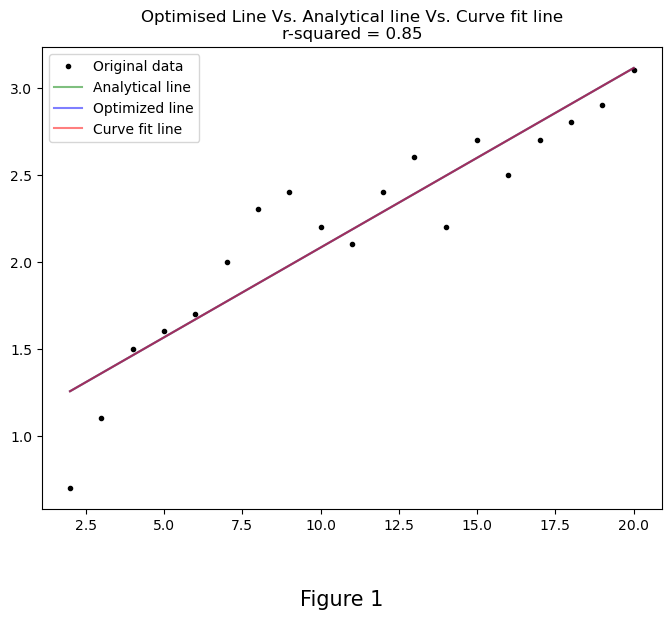

In [7]:
# Plot the best fit line from the optimization.
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(x, y, 'k.', label='Original data')
ax.plot(x, m_a * x + c_a, 'g-', label = 'Analytical line', alpha = 0.5)
ax.plot(x, m_o * x + c_o, 'b-', label = 'Optimized line', alpha = 0.5)
ax.plot(x, m_f * x + c_f, 'r-', label = 'Curve fit line', alpha = 0.5)

# calculate r-squared val
rsq = np.corrcoef(x, y)[0][1]**2

# format plot
plt.figtext(0.5, -0.05, 'Figure 1', wrap = True, horizontalalignment = 'center', fontsize = 15);
ax.set_title("Optimised Line Vs. Analytical line Vs. Curve fit line\n{}"
             .format('r-squared = %.2f' % (rsq)))
ax.legend()
plt.show()

<h2 style="color: rgb(0, 91, 94);">References</h2>

<hr style="border-top: 1px solid rgb(0, 91, 94);" />


[1]. x, y, 2020,  title, towards data science, Available at:
[]() (Accessed x November 2022).


<hr style="border-top: 1px solid rgb(0, 91, 94);" />

<h2 style="color: rgb(0, 91, 94);">End</h2>